In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import os

# Create the animation readingr from binary file
# Make sure these entries match those used in the simulation
N_CELL_X = 200
N_CELL_Y = 50
totalSteps = 20_000
saveEvery = 40
beta = 1/0.5
rho = 10
epsilon = 0.9
flux_active = True   

interesting_frame = 3085
threshold = 200


prestring = "f" if flux_active else ""
frames = totalSteps // saveEvery
filename = f"./AIMData/Nx{N_CELL_X}_Ny{N_CELL_Y}_beta{beta:.3f}_eps{epsilon:.3f}_rho{rho:.2f}_Ntot{totalSteps}_Nevry{saveEvery}{prestring}.dat"
print("Loading file:", filename)

size_mag = N_CELL_X * N_CELL_Y
size_den = N_CELL_X * N_CELL_Y
size_flux = N_CELL_X if flux_active else 0

frame_bytes = (size_mag + size_den + size_flux) * 4  
def read_frame(f):
    raw = f.read(frame_bytes)
    if len(raw) < frame_bytes:
        return None

    offset = 0
    mag = np.frombuffer(raw[offset:offset + size_mag*4], dtype=np.int32).reshape(N_CELL_X, N_CELL_Y)
    offset += size_mag * 4

    den = np.frombuffer(raw[offset:offset + size_den*4], dtype=np.int32).reshape(N_CELL_X, N_CELL_Y)
    offset += size_den * 4

    if flux_active:
        flux = np.frombuffer(raw[offset:offset + size_flux*4], dtype=np.int32)
    else:
        flux = None

    return mag, den, flux

fig, axs = plt.subplots(
    3, 1,
    figsize=(14, 10),
    gridspec_kw={'height_ratios': [2, 2, 0.7]}
)

with open(filename, "rb") as f:
    first = read_frame(f)
    if first is None:
        raise RuntimeError("No file found")
    mag0, den0, flux0 = first

im_mag = axs[0].imshow(mag0.T, cmap="gray", origin="lower", aspect="auto", vmin=-1, vmax=1)
axs[0].set_title("Magnetization per cell")
plt.colorbar(im_mag, ax=axs[0], fraction=0.046)

im_den = axs[1].imshow(den0.T, cmap="viridis", origin="lower", aspect="auto", vmin = 0, vmax = 12)
axs[1].set_title("Density per cell")
plt.colorbar(im_den, ax=axs[1], fraction=0.046)

if flux_active:
    im_flux = axs[2].imshow(flux0.reshape(1, -1), cmap="seismic", aspect="auto", vmin = -300, vmax = 300)
    axs[2].set_title("Flux by column")
    plt.colorbar(im_flux, ax=axs[2], fraction=0.046)
else:
    im_flux = None

plt.tight_layout()

# Create video
output_file = "simulation.mp4"
writer = FFMpegWriter(fps=30, bitrate=6000)
print("Rendering video...")

global_avg_mag = np.zeros(N_CELL_X)
global_avg_den = np.zeros(N_CELL_X)
global_avg_flux = np.zeros(N_CELL_X) if flux_active else None

with writer.saving(fig, output_file, dpi=150):
    with open(filename, "rb") as f:
        for frame_index in range(frames):
            frame = read_frame(f)

            if frame is None:
                break

            mag, den, flux = frame

            # Update figures
            im_mag.set_data(mag.T)
            im_den.set_data(den.T)
            
            if flux_active:
                im_flux.set_data(flux.reshape(1, -1))

            axs[0].set_title(f"Magnetization – Frame {frame_index}/{frames-1}")
            if (interesting_frame == frame_index):
                # save to a pdf file just this interesting frame
                fig.savefig(f"interesting_frame_{frame_index}.pdf")
                # Build here the graph for magnetization profile along x at center y
                plt.figure()
                profile_mag = np.mean(mag, axis = 1)
                profile_den = np.mean(den, axis = 1)
                plt.plot(profile_mag, label="Magnetization profile")
                plt.plot(profile_den, label="Density profile")
                plt.xlabel("x")
                plt.ylabel("Magnetization/Density")
                plt.ylim(-5,5)
                plt.legend()
                plt.grid()
                #plt.savefig(f"magnetization_profile_{frame_index}.pdf")
                plt.close()
            
            if (frame_index > threshold):
                global_avg_mag += np.mean(mag, axis = 1) / (frames - threshold)
                global_avg_den += np.mean(den, axis = 1) / (frames - threshold)
                if flux_active:
                    global_avg_flux += flux / (frames - threshold)

            # Write frame to video
            writer.grab_frame()

            if frame_index % 100 == 0:
                print(f"  Frame {frame_index}/{frames}")

print(f"Video saved as: {output_file}")


Caricamento file: ./AIMData/Nx200_Ny50_beta2.000_eps0.900_rho10.00_Ntot20000_Nevry40f.dat


Let's plot the profiles for a given frame of interest:

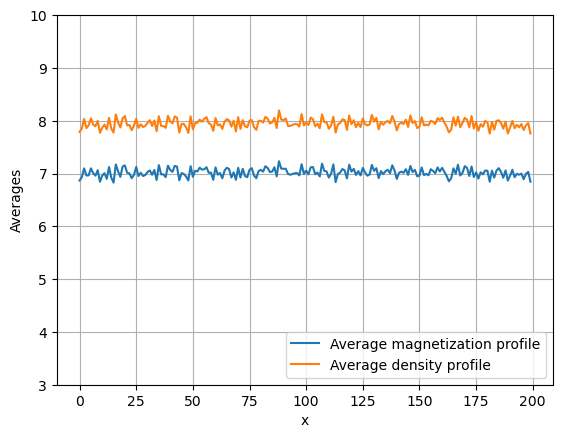

In [ ]:
# plot those averages
plt.figure()
plt.plot(np.abs(global_avg_mag), label="Average magnetization profile")
plt.plot(global_avg_den, label="Average density profile")
plt.xlabel("x")
plt.ylabel("Averages")
plt.legend(loc = "lower right")
plt.grid()
plt.ylim(3,10)
#plt.savefig("liquid_plots.pdf")
plt.show()

Now let's visualize the heatmap using the order parameter $r = \frac{|\langle m \rangle|}{\rho}$

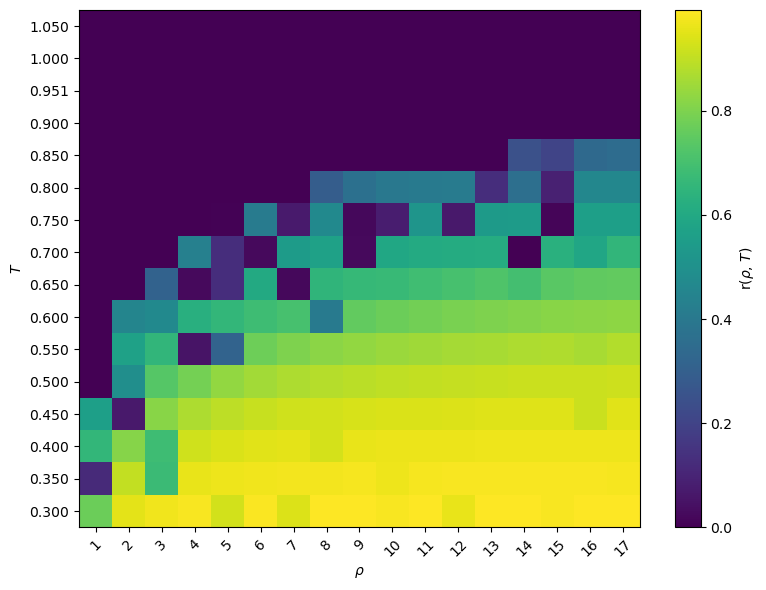

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
#Load data
data = pd.read_csv("./AIMData/magden.txt", sep=r"\s+", header=None, names=["x", "y", "f"])

data["x_inv"] = 1 / data["x"]
pivot = data.pivot(index="x_inv", columns="y", values="f")
pivot = pivot.sort_index().sort_index(axis=1)

plt.figure(figsize=(8, 6))
plt.imshow(pivot.values, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label="r($\\rho$, $T$)")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), [f"{v:.3f}" for v in pivot.index])
plt.xlabel(r"$\rho$")
plt.ylabel("$T$")
plt.tight_layout()

plt.show()

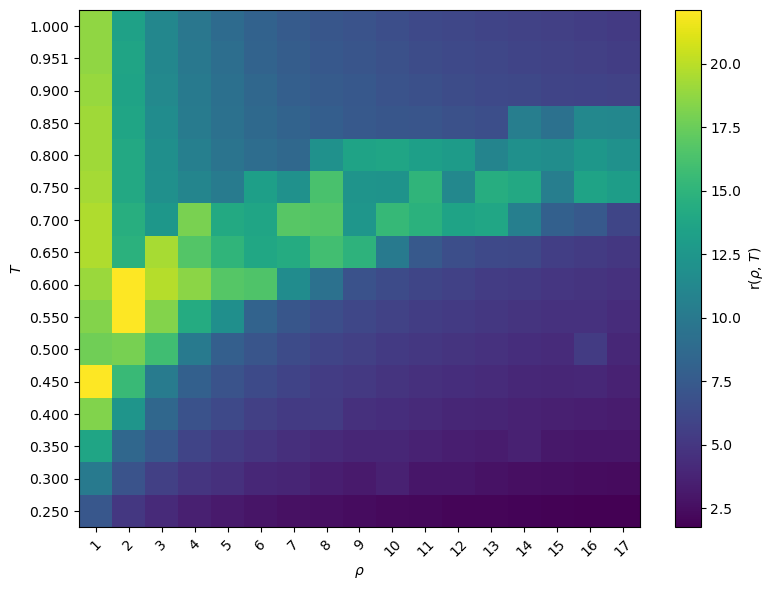

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("./AIMData/flux.txt", sep=r"\s+", header=None, names=["x", "y", "f"])
data["x_inv"] = 1 / data["x"]
pivot = data.pivot(index="x_inv", columns="y", values="f")

pivot = pivot.sort_index().sort_index(axis=1)

normalized_pivot = pivot.copy()
for y_value in normalized_pivot.columns:
    normalized_pivot[y_value] = normalized_pivot[y_value]  / (y_value*50)

plt.figure(figsize=(8, 6))
plt.imshow(normalized_pivot.values, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label="r($\\rho$, $T$)")

plt.xticks(range(len(normalized_pivot.columns)), normalized_pivot.columns, rotation=45)
plt.yticks(range(len(normalized_pivot.index)), [f"{v:.3f}" for v in normalized_pivot.index])
plt.xlabel(r"$\rho$")
plt.ylabel("$T$")
plt.tight_layout()

plt.show()

---
Now let's keep $T$ fixed and vary $\epsilon$ and $\rho$:

<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_6395/2528067783.py:11: SyntaxWarning: invalid escape sequence '\e'
  plt.colorbar(label="r($\\rho$, $\epsilon$)")


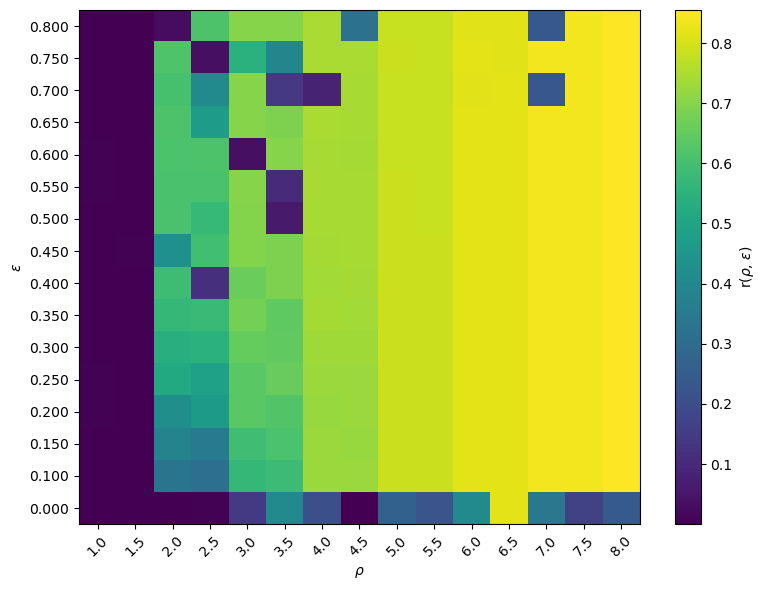

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
#Load data
data = pd.read_csv("./AIMData/magden_epsilon.txt", sep=r"\s+", header=None, names=["x", "y", "f"])

pivot = data.pivot(index="x", columns="y", values="f")
pivot = pivot.sort_index().sort_index(axis=1)

plt.figure(figsize=(8, 6))
plt.imshow(pivot.values, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label="r($\\rho$, $\epsilon$)")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), [f"{v:.3f}" for v in pivot.index])
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\epsilon$")
plt.tight_layout()

plt.show()

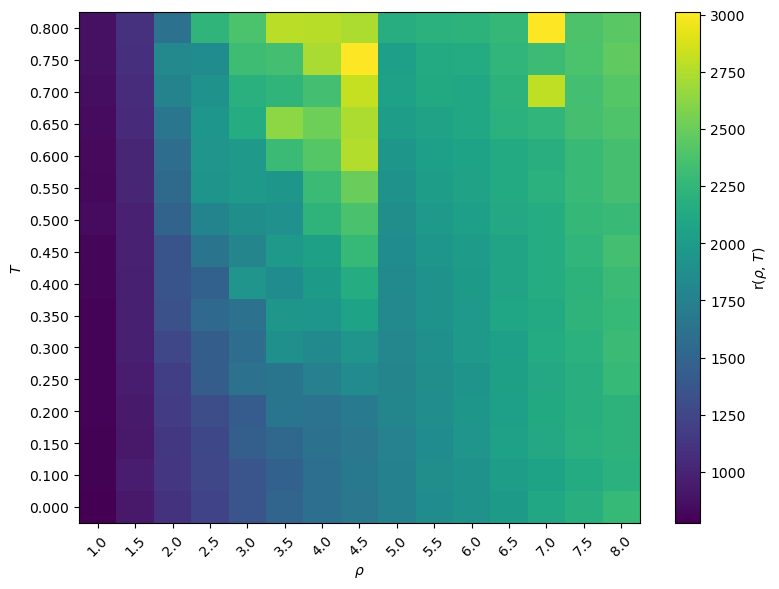

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("./AIMData/flux_epsilon.txt", sep=r"\s+", header=None, names=["x", "y", "f"])
pivot = data.pivot(index="x", columns="y", values="f")

pivot = pivot.sort_index().sort_index(axis=1)

normalized_pivot = pivot.copy()
for y_value in normalized_pivot.columns:
    normalized_pivot[y_value] = normalized_pivot[y_value] 

plt.figure(figsize=(8, 6))
plt.imshow(normalized_pivot.values, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label="r($\\rho$, $T$)")

plt.xticks(range(len(normalized_pivot.columns)), normalized_pivot.columns, rotation=45)
plt.yticks(range(len(normalized_pivot.index)), [f"{v:.3f}" for v in normalized_pivot.index])
plt.xlabel(r"$\rho$")
plt.ylabel("$T$")
plt.tight_layout()

plt.show()
